In [ ]:
!pip install -q -r '/content/requirements.txt'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6

In [ ]:
import numpy as np
import pandas as pd
import streamlit as st
import torch
from PIL import Image
from io import BytesIO
import requests
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,DBSCAN # Kmeans for Centroidal Cluserting while DBSCAN for density based
from transformers import CLIPProcessor,CLIPModel
from PIL import UnidentifiedImageError
import plotly.express as px
from tqdm import tqdm
import matplotlib.pyplot as plt
#import supervision as sv
import random

device="cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor=CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

from datasets import load_dataset

#dataset=load_dataset("isidentical/moondream2-coyo-5M-captions")['train']
n=100 #number of samples
#dataset=dataset[:n]


dataset = load_dataset("isidentical/moondream2-coyo-5M-captions")['train']
dataset=dataset[:5]

In [ ]:
dataset

{'key': ['00000117', '00000045', '00000178', '00000143', '00000238'],
 'url': ['http://www.worldwisdom.com/uploads/gallery/369.jpg',
  'http://www.floresta.com.my/content/images/thumbs/0001068_vd069-36-roses_600.jpeg',
  'http://aixakt-schreinerei.de/wp-content/uploads/2016/11/NIK_9001.jpg',
  'http://i.bosscdn.com/uploads/9f/e2/1d/f17f2fd0f8a614ff47cfbc77ed.jpg',
  'http://midgecolemanfineart.com/images/paintings---studio/AF3245EE39334B1F86BC2B77A65C806B/P1002104_thumb.png'],
 'alt_text': ['"The Delights of Childhood - Hopi", by Edward S. Curtis from The North American Indian Volume 12',
  'Picture of VD069 - 36 Roses',
  'Mangold Asian Pacific Cuisine',
  'Factory Supply Floating Glass Living Locket Jewelry Necklace Pendant',
  'A Time to Turn 20x24 - $500 La Verna'],
 'moondream2_caption': ['Two young girls crouched and gathered around a piece of food on the ground, in what appears to be an old-fashioned photograph capturing the simpler pleasures of childhood.\n',
  'A decorative fl

In [106]:
def plot_images_grid(images,text,grid_size=(5, 5), titles=None, size=(5, 5), cmap=None):
    from math import ceil

    nrows, ncols = grid_size
    fig, axes = plt.subplots(nrows, ncols, figsize=size)

    if nrows == 1 and ncols == 1:
        axes = [axes]  # Make axes iterable if it's a single Axes object
    else:
        axes = axes.flatten()

    for idx, (img,txt) in enumerate(zip(images,text)):
        if isinstance(img, Image.Image):
            img = img.convert("RGB")
        if cmap:
            axes[idx].imshow(img, cmap=cmap)
        else:
            axes[idx].imshow(img)

        axes[idx].set_title(txt, fontsize=10)

        axes[idx].axis('off')


    for ax in axes[len(images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

dataframe=pd.DataFrame()
def get_image_embeddings(data):
    error_count = 0
    error_urls = []
    image_embeddings = []
    coutn=0
    data_text=data['moondream2_caption']
    data_url=data['url']

    dataframe=pd.DataFrame({'url':data_url,'text':data_text})
    for _,row in dataframe.iterrows():
            image_url = row['url']
            text=row['text']
            try:
                coutn+=1

                if coutn == 50:
                    break

                response = requests.get(image_url)
                response.raise_for_status()  # Raise an exception for non-2xx status codes

                # Check if the content type is an image
                image=Image.open(BytesIO(response.content))
                plot_images_grid([image],[text], grid_size=(1, 1))


                inputs=processor(images=image,return_tensors="pt").to(device)
                with torch.no_grad():
                    image_embedding=model.get_image_features(**inputs)
                image_embeddings.append(image_embedding.squeeze().cpu().numpy())

            except (requests.exceptions.RequestException, UnidentifiedImageError, ValueError) as e:
                error_urls.append(image_url)
                error_count += 1

    return image_embeddings,dataframe




def apply_pca(image_embeddings,n_components=3):
    pca=PCA(n_components=n_components)
    return pca.fit_transform(image_embeddings)

def apply_umap(image_embeddings,n_components=3):
    umap=umap.UMAP(n_components=n_components)
    return umap.fit_transform(image_embeddings)

def apply_tsne(image_embeddings,n_components=3):
    tsne=TSNE(n_components=n_components)
    return tsne.fit_transform(image_embeddings)

def apply_dbscan(embeddings, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(embeddings)
    return labels

def cluster_embeddings(embeddings, method='KMeans', n_clusters=5):
    if method == 'KMeans':
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(embeddings)
    elif method == 'DBSCAN':
        labels = apply_dbscan(embeddings)
    return labels



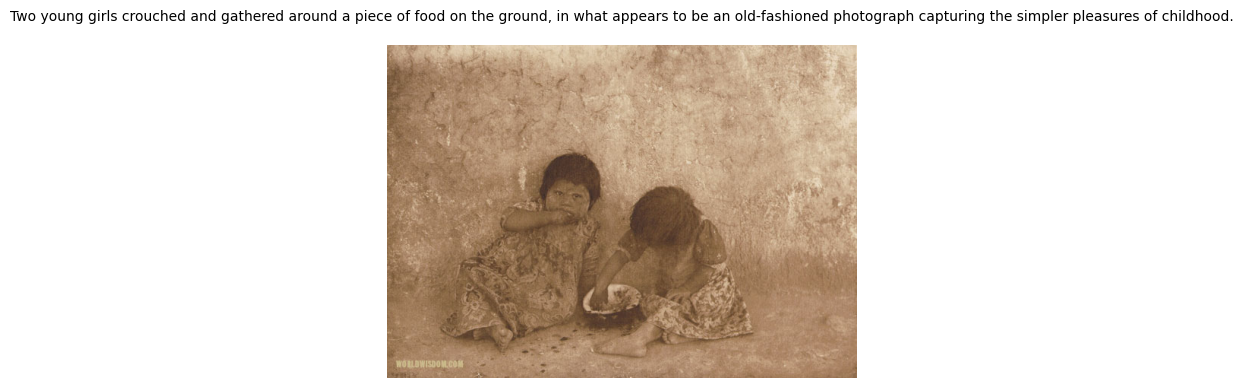

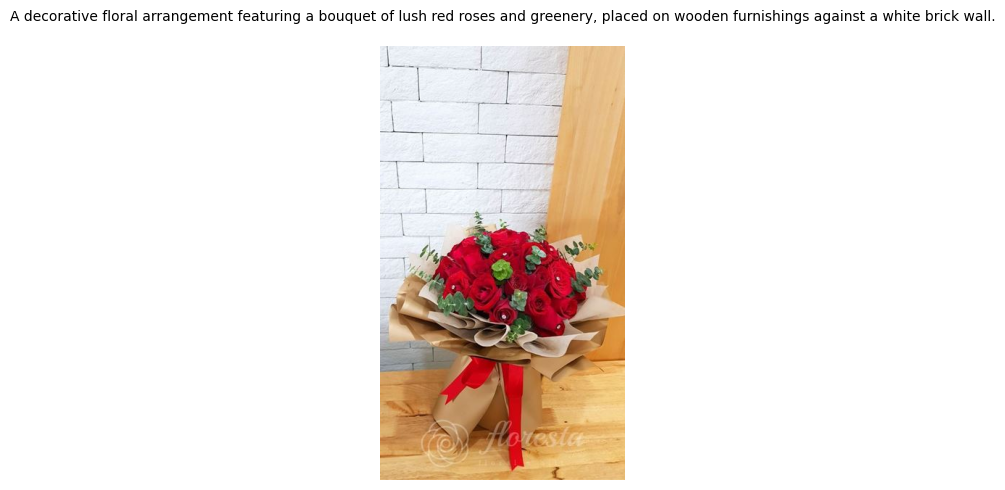

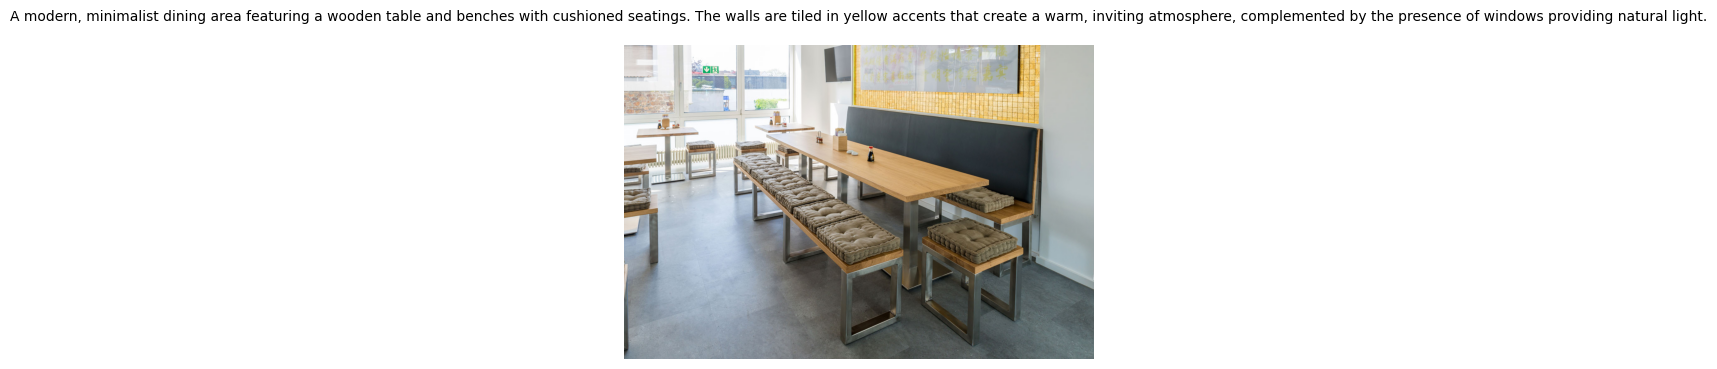

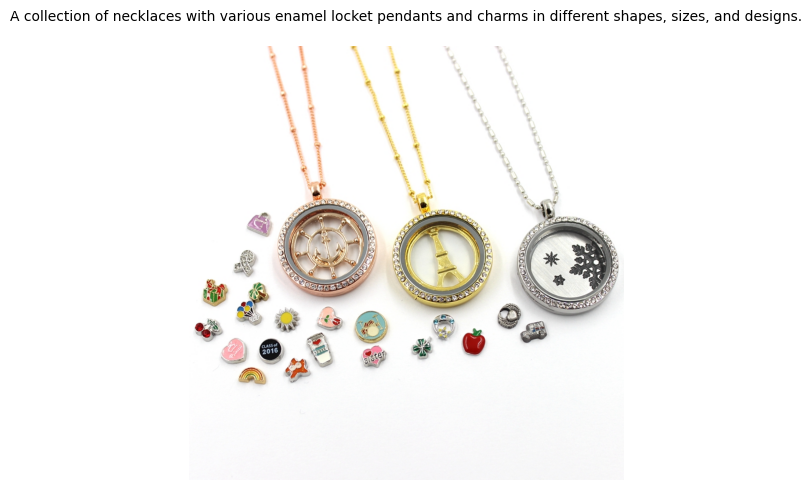

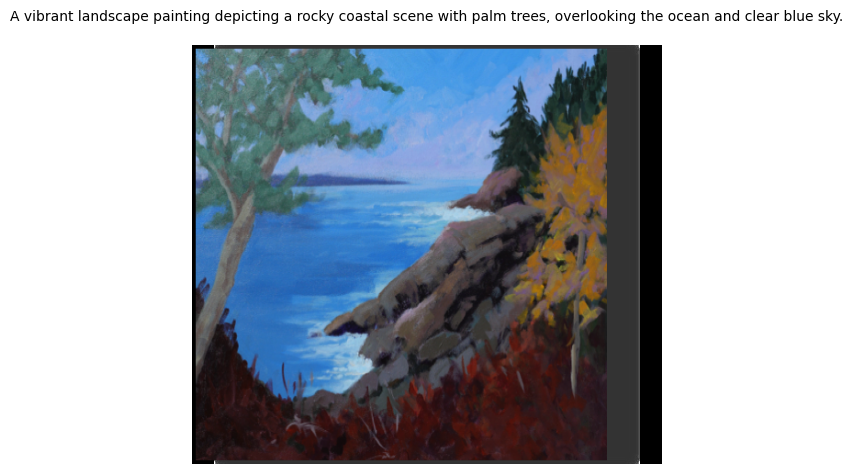

In [107]:
def visualize_embeddings(image_embeddings_transformed,labels,method,dataset,n_clusters):

    plt.figure(figsize=(10, 10))
    fig = px.scatter_3d(
    x=image_embeddings_transformed[:, 0],
    y=image_embeddings_transformed[:, 1],
    z=image_embeddings_transformed[:, 2],
    title= f"3D Scatter Plot of {method} Reduced Data",
    labels={'x': 'Component 1', 'y': 'Component 2', 'z': 'Component 3'},
    color=labels.astype(str),
    symbol=labels.astype(str),
    opacity=0.7
    #hover_data=dataset['text']
    )

    fig.update_traces(
    showlegend=True,
    selector=dict(type='scatter3d'),
    name='Cluster')

    # Set legend labels
    fig.update_layout(
        legend=dict(
            title='Cluster Labels',
            itemsizing='constant'
        )
    )

    st.plotly_chart(fig)

image_embeddings,dataframe=get_image_embeddings(dataset)

In [ ]:
st.title("CLIP Image Embeddings")
st.sidebar.text("The dataset is Subset of COYO 400M Image-Text pairs")
dim_reduction=st.selectbox("Choose Dimension Reduction Technique",['PCA','UMAP','T-SNE'])
clustering_algo=st.selectbox("Choose the clustering method", ['DBSCAN','K-MEANS'])
n_cluster=st.slider("Number of clusters", 2,10,2) if clustering_algo=="K-MEANS" else None




if dim_reduction == "PCA":
        reduced_embeddings = apply_pca(image_embeddings)
elif dim_reduction == "UMAP":
        reduced_embeddings = apply_umap(image_embeddings)
elif dim_reduction == "T-SNE":
        reduced_embeddings = apply_tsne(image_embeddings)

print(reduced_embeddings)
labels = cluster_embeddings(reduced_embeddings, method=clustering_algo, n_clusters=n_cluster)
visualize_embeddings(reduced_embeddings, labels,clustering_algo,dataframe,n_cluster)

[[ 6.86183667 -3.0188684   0.85414099]
 [-2.86935832 -3.57915454 -4.14931147]
 [-2.88029724 -0.12555946  5.50777799]
 [-2.84239523  0.33892699 -0.4210911 ]
 [ 1.73021412  6.38465541 -1.79151641]]


<Figure size 1000x1000 with 0 Axes>